In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
def build_model(my_learning_rate, inputs, outputs):
  model = tf.keras.Model(inputs = inputs, outputs= outputs)
  model.compile(optimizer = tf.keras.optimizers.experimental.RMSprop(learning_rate= my_learning_rate),
                loss= "mean_absolute_error",
                metrics = tf.keras.metrics.RootMeanSquaredError())
  return model

def train_model(model, df, label_name, epochs, batch_size):
  feature = {name:np.array(value) for name, value in df.items()}
  label = np.array(feature.pop(label_name))

  history = model.fit(x= feature, y = label, epochs= epochs, batch_size= batch_size)

  epochs = history.epoch

  hist = pd.DataFrame(history.history)
  rmse = hist["root_mean_squared_error"]

  return hist, epochs, rmse

In [7]:
train_df = pd.read_csv("/content/sample_data/california_housing_train.csv")
test_df = pd.read_csv("/content/sample_data/california_housing_test.csv")

train_df = train_df.reindex(np.random.permutation(train_df.index))
test_df = test_df.reindex(np.random.permutation(test_df.index))

scale_factor = 1000
train_df /= scale_factor
test_df /= scale_factor

train_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
3255,-0.11786,0.03378,0.021,2.713,0.731,1.952,0.722,0.002696,178.8
7609,-0.11837,0.03409,0.038,1.349,0.344,0.547,0.309,0.003216,383.3
4318,-0.11801,0.03381,0.025,1.831,0.345,0.809,0.339,0.004518,177.1
13261,-0.12191,0.03729,0.036,0.945,0.149,0.371,0.158,0.005627,320.5
929,-0.11708,0.03257,0.009,6.298,1.512,4.451,1.456,0.002569,88.3


In [8]:
def plot_the_loss_curve(epochs, rmse):
  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Root Mean Squared Error")

  plt.plot(epochs, rmse, label="Loss")
  plt.legend()
  plt.ylim([rmse.min()*0.97, rmse.max()])
  plt.show()

In [9]:
input={
    "latitude": tf.keras.layers.Input(shape= (1,), dtype= tf.float32, name="Latitude"),
    "longitude":tf.keras.layers.Input(shape= (1,), dtype= tf.float32, name= "Longitude")
}

In [10]:
resolution_degree = 1.0

latitude_boundaries = list(np.arange(int(min(train_df["latitude"])),
                                     int(max(train_df["latitude"])),
                                     resolution_degree))

latitude = tf.keras.layers.Discretization(
    bin_boundaries= latitude_boundaries,
    name = "Discretization_LatitudeLayer"
)(input.get("latitude"))

latitude = tf.keras.layers.CategoryEncoding(
    num_tokens= len(latitude_boundaries) + 1,
    output_mode = "one_hot",
    name= "Latitude_CategoryEncoding_Layer"
)(latitude)


longitude_boundaries = list(np.arange(
    int(min(train_df["longitude"])),
    int(max(train_df["longitude"])),
    resolution_degree
    ))

longitude = tf.keras.layers.Discretization(
    bin_boundaries = longitude_boundaries,
    name = "Discreatization_LongitudeLayer"
)(input.get("longitude"))

longitude = tf.keras.layers.CategoryEncoding(
    num_tokens = len(longitude_boundaries) + 1,
    output_mode = "one_hot",
    name= "Longitude_CategoryEncoding_Layer"
)(longitude)

Concatenate = tf.keras.layers.Concatenate()([latitude, longitude])
dense_output = tf.keras.layers.Dense(units = 1, name= "Dense_Output")(Concatenate)

output = {
    "Output": dense_output
}

In [ ]:
learning_rate = 0.1
epochs = 35
batch_size = 10
label_name = "median_house_value"

model = build_model(learning_rate, input, output)
hist, epochs, rmse = train_model(model, train_df, label_name, epochs, batch_size)

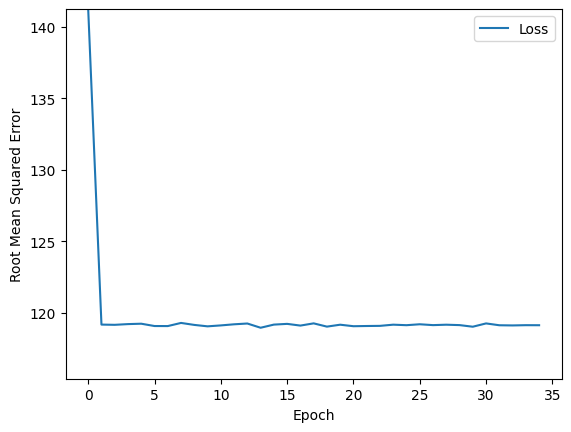

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Latitude (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 Longitude (InputLayer)      [(None, 1)]                  0         []                            
                                                                                                  
 Discretization_LatitudeLay  (None, 1)                    0         ['Latitude[0][0]']            
 er (Discretization)                                                                              
                                                                                                  
 Discreatization_LongitudeL  (None, 1)                    0         ['Longitude[0][0]']       

In [12]:
plot_the_loss_curve(epochs, rmse)
model.summary()

In [13]:
test_features = {name:np.array(values) for name, values in test_df.items()}
test_label = np.array(test_features.pop(label_name))
model.evaluate(x=test_features, y=test_label, batch_size=batch_size)

 31/300 [==>...........................] - ETA: 0s - loss: 82.9765 - root_mean_squared_error: 111.5879  

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


300/300 [==============================] - 1s 2ms/step - loss: 86.6040 - root_mean_squared_error: 116.9304


[86.60404968261719, 116.93042755126953]